# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [2]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,16 secs
H2O cluster version:,3.10.4.4
H2O cluster version age:,1 month and 27 days
H2O cluster name:,H2O_from_python_yataolu_sxebkd
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,0
H2O cluster allowed cores:,0
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Import data

In [5]:
train = h2o.import_file('../Desktop/train.csv')
test = h2o.import_file('../Desktop/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [6]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [7]:
original_nums, cats = get_type_lists()

('Numeric =', [u'3SsnPorch', u'GarageYrBlt', u'OverallQual', u'LotArea', u'GrLivArea', u'YearRemodAdd', u'EnclosedPorch', u'BsmtFullBath', u'LotFrontage', u'KitchenAbvGr', u'MoSold', u'OpenPorchSF', u'BsmtUnfSF', u'FullBath', u'MSSubClass', u'YearBuilt', u'PoolArea', u'LowQualFinSF', u'2ndFlrSF', u'HalfBath', u'OverallCond', u'WoodDeckSF', u'MasVnrArea', u'1stFlrSF', u'MiscVal', u'Fireplaces', u'BsmtHalfBath', u'TotalBsmtSF', u'TotRmsAbvGrd', u'YrSold', u'BsmtFinSF1', u'BsmtFinSF2', u'ScreenPorch', u'BedroomAbvGr', u'GarageArea', u'GarageCars'])
()
('Categorical =', [u'MasVnrType', u'LotConfig', u'GarageFinish', u'Electrical', u'HouseStyle', u'Foundation', u'HeatingQC', u'CentralAir', u'BsmtExposure', u'GarageCond', u'PavedDrive', u'SaleType', u'KitchenQual', u'BsmtFinType2', u'BsmtFinType1', u'Condition2', u'Condition1', u'Fence', u'SaleCondition', u'Functional', u'Alley', u'MiscFeature', u'PoolQC', u'LandSlope', u'GarageQual', u'Exterior1st', u'BsmtQual', u'BsmtCond', u'Utilities', u

## Split into to train and validation (before doing data prep!!!)

In [8]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [9]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [10]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [11]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: MasVnrType (1/43) ...
Encoding: LotConfig (2/43) ...
Encoding: GarageFinish (3/43) ...
Encoding: Electrical (4/43) ...
Encoding: HouseStyle (5/43) ...
Encoding: Foundation (6/43) ...
Encoding: HeatingQC (7/43) ...
Encoding: CentralAir (8/43) ...
Encoding: BsmtExposure (9/43) ...
Encoding: GarageCond (10/43) ...
Encoding: PavedDrive (11/43) ...
Encoding: SaleType (12/43) ...
Encoding: KitchenQual (13/43) ...
Encoding: BsmtFinType2 (14/43) ...
Encoding: BsmtFinType1 (15/43) ...
Encoding: Condition2 (16/43) ...
Encoding: Condition1 (17/43) ...
Encoding: Fence (18/43) ...
Encoding: SaleCondition (19/43) ...
Encoding: Functional (20/43) ...
Encoding: Alley (21/43) ...
Encoding: MiscFeature (22/43) ...
Encoding: PoolQC (23/43) ...
Encoding: LandSlope (24/43) ...
Encoding: GarageQual (25/43) ...
Encoding: Exterior1st (26/43) ...
Encoding: BsmtQual (27/43) ...
Encoding: BsmtCond (28/43) ...
Encoding: Utilities (29/43) ...
Encoding: LotShape (30/43) ...
Encoding: BldgType (31/43) ...


#### Redefine numerics and explore

In [12]:
encoded_nums, cats = get_type_lists(frame=train)

('Numeric =', [u'3SsnPorch', u'Heating_Tencode', u'GarageYrBlt', u'OverallQual', u'LotArea', u'Condition2_Tencode', u'HeatingQC_Tencode', u'GrLivArea', u'YearRemodAdd', u'BsmtFinType2_Tencode', u'EnclosedPorch', u'Street_Tencode', u'BsmtFullBath', u'MiscFeature_Tencode', u'LotFrontage', u'SaleCondition_Tencode', u'KitchenAbvGr', u'FireplaceQu_Tencode', u'MoSold', u'KitchenQual_Tencode', u'Foundation_Tencode', u'GarageCond_Tencode', u'OpenPorchSF', u'BsmtUnfSF', u'ExterCond_Tencode', u'2ndFlrSF', u'Electrical_Tencode', u'Exterior1st_Tencode', u'GarageQual_Tencode', u'FullBath', u'HouseStyle_Tencode', u'ExterQual_Tencode', u'CentralAir_Tencode', u'RoofStyle_Tencode', u'MSSubClass', u'YearBuilt', u'PoolArea', u'Exterior2nd_Tencode', u'BsmtQual_Tencode', u'LotConfig_Tencode', u'PavedDrive_Tencode', u'LowQualFinSF', u'BsmtFinType1_Tencode', u'GarageType_Tencode', u'RoofMatl_Tencode', u'HalfBath', u'BldgType_Tencode', u'Alley_Tencode', u'OverallCond', u'Utilities_Tencode', u'BsmtCond_Tencode

In [13]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




,3SsnPorch,Heating_Tencode,GarageYrBlt,OverallQual,LotArea,Condition2_Tencode,HeatingQC_Tencode,GrLivArea,YearRemodAdd,BsmtFinType2_Tencode,EnclosedPorch,Street_Tencode,BsmtFullBath,MiscFeature_Tencode,LotFrontage,SaleCondition_Tencode,KitchenAbvGr,FireplaceQu_Tencode,MoSold,KitchenQual_Tencode,Foundation_Tencode,GarageCond_Tencode,OpenPorchSF,BsmtUnfSF,ExterCond_Tencode,2ndFlrSF,Electrical_Tencode,Exterior1st_Tencode,GarageQual_Tencode,FullBath,HouseStyle_Tencode,ExterQual_Tencode,CentralAir_Tencode,RoofStyle_Tencode,MSSubClass,YearBuilt,PoolArea,Exterior2nd_Tencode,BsmtQual_Tencode,LotConfig_Tencode,PavedDrive_Tencode,LowQualFinSF,BsmtFinType1_Tencode,GarageType_Tencode,RoofMatl_Tencode,HalfBath,BldgType_Tencode,Alley_Tencode,OverallCond,Utilities_Tencode,BsmtCond_Tencode,LandSlope_Tencode,WoodDeckSF,MasVnrArea,1stFlrSF,GarageFinish_Tencode,MiscVal,Fireplaces,BsmtHalfBath,TotalBsmtSF,TotRmsAbvGrd,BsmtFinSF2,Condition1_Tencode,Neighborhood_Tencode,MasVnrType_Tencode,Functional_Tencode,YrSold,MSZoning_Tencode,PoolQC_Tencode,Fence_Tencode,BsmtFinSF1,BsmtExposure_Tencode,ScreenPorch,BedroomAbvGr,LotShape_Tencode,SaleType_Tencode,LandContour_Tencode,GarageArea,GarageCars
type,int,real,real,int,int,real,real,int,int,real,int,real,int,real,real,real,int,real,int,real,real,real,int,int,real,int,real,real,real,int,real,real,real,real,int,int,int,real,real,real,real,int,real,real,real,int,real,real,int,real,real,real,int,real,int,real,int,int,int,int,int,int,real,real,real,real,int,real,real,real,int,real,int,int,real,real,real,int,int
mins,0.0,93469.9605228,1908.0,2.0,1300.0,108075.793856,135668.699029,480.0,1950.0,154536.935523,0.0,146350.103856,0.0,140375.793856,21.0,115832.043856,0.0,141462.348856,1.0,124936.948204,121726.893856,112070.793856,0.0,0.0,122047.149412,0.0,84275.7938561,78325.7938561,96813.2938561,0.0,118907.222428,116078.968856,119608.233687,161577.222428,20.0,1875.0,0.0,129978.239689,121216.120939,176473.289916,129253.89465,0.0,150410.446488,125174.960523,143775.793856,0.0,138273.460523,128075.200999,2.0,144200.793856,84275.7938561,181486.518275,0.0,0.0,480.0,141354.57177,0.0,0.0,0.0,0.0,3.0,0.0,134468.293856,109690.793856,155578.618881,110059.127189,2006.0,78614.7938561,182171.959041,141306.738142,0.0,167645.412308,0.0,0.0,163944.593856,125968.293856,145140.162856,0.0,0.0
mean,3.45654345654,182323.57986,1978.73452256,6.14485514486,10628.2627373,182224.44204,182409.708563,1519.8011988,1985.13886114,184056.757876,21.2577422577,182203.534984,0.426573426573,181198.192241,70.599756691,181541.324945,1.04695304695,200266.801149,6.36263736264,180810.97024,183119.902423,186002.746716,44.9240759241,575.99000999,182637.235059,341.787212787,182952.641282,183565.713794,186018.329715,1.57442557443,183188.256353,181095.696027,182822.70708,182159.008694,57.0879120879,1972.2987013,3.37662337662,183994.526093,182245.412787,181772.161181,182908.18056,5.92507492507,185645.795152,185255.622658,182033.940055,0.381618381618,182849.797976,180171.385469,5.58341658342,182178.653141,184043.119008,182145.055669,91.0739260739,106.911468813,1172.08891109,185712.872162,39.6843156843,0.62037962038,0.0599400599401,1063.23876124,6.51248751249,41.6493506494,182645.117764,182171.959041,180574.40005,182576.245337,2007.82817183,183387.926402,182802.825683,177450.87031,445.599400599,182844.625291,14.7632367632,2.87112887113,181993.927863,181180.33117,182186.732997,477.468531469,1.79320679321
maxs,508.0,185483.958142,2010.0,10.0,164660.0,269469.543856,216426.0,5642.0,2010.0,218122.460523,552.0,182383.522088,3.0,239825.793856,313.0,260380.616748,3.0,306119.08333,12.0,305958.087692,226465.827434,188146.750273,523.0,2153.0,185708.339408,2065.0,187738.312704,250025.793856,222252.043856,3.0,210965.119205,348876.587446,186782.0,248325.793856,190.0,2010.0,738.0,298475.793856,312352.666531,215932.781356,187523.867102,528.0,236446.986486,243875.54558,669075.793856,2.0,187595.754197,182171.959041,9.0,182216.631,212500.143856,200379.843856,736.0,1378.0,4692.0,243708

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




,3SsnPorch,Heating_Tencode,GarageYrBlt,OverallQual,LotArea,Condition2_Tencode,HeatingQC_Tencode,GrLivArea,YearRemodAdd,BsmtFinType2_Tencode,EnclosedPorch,Street_Tencode,BsmtFullBath,MiscFeature_Tencode,LotFrontage,SaleCondition_Tencode,KitchenAbvGr,FireplaceQu_Tencode,MoSold,KitchenQual_Tencode,Foundation_Tencode,GarageCond_Tencode,OpenPorchSF,BsmtUnfSF,ExterCond_Tencode,2ndFlrSF,Electrical_Tencode,Exterior1st_Tencode,GarageQual_Tencode,FullBath,HouseStyle_Tencode,ExterQual_Tencode,CentralAir_Tencode,RoofStyle_Tencode,MSSubClass,YearBuilt,PoolArea,Exterior2nd_Tencode,BsmtQual_Tencode,LotConfig_Tencode,PavedDrive_Tencode,LowQualFinSF,BsmtFinType1_Tencode,GarageType_Tencode,RoofMatl_Tencode,HalfBath,BldgType_Tencode,Alley_Tencode,OverallCond,Utilities_Tencode,BsmtCond_Tencode,LandSlope_Tencode,WoodDeckSF,MasVnrArea,1stFlrSF,GarageFinish_Tencode,MiscVal,Fireplaces,BsmtHalfBath,TotalBsmtSF,TotRmsAbvGrd,BsmtFinSF2,Condition1_Tencode,Neighborhood_Tencode,MasVnrType_Tencode,Functional_Tencode,YrSold,MSZoning_Tencode,PoolQC_Tencode,Fence_Tencode,BsmtFinSF1,BsmtExposure_Tencode,ScreenPorch,BedroomAbvGr,LotShape_Tencode,SaleType_Tencode,LandContour_Tencode,GarageArea,GarageCars
type,int,real,real,int,int,real,real,int,int,real,int,real,int,real,real,real,int,real,int,real,real,real,int,int,real,int,real,real,real,int,real,real,real,real,int,int,int,real,real,real,real,int,real,real,real,int,real,real,int,real,real,real,int,real,int,real,int,int,int,int,int,int,real,real,real,real,int,real,real,real,int,real,int,int,real,real,real,int,int
mins,0.0,77729.0245098,1900.0,1.0,1491.0,84954.0245098,100679.02451,334.0,1950.0,145091.52451,0.0,95579.0245098,0.0,73479.0245098,21.0,143816.52451,1.0,133191.52451,1.0,105130.89951,110363.317367,118776.941176,0.0,0.0,91754.0245098,0.0,100143.52451,96429.0245098,134853.203676,0.0,122402.595938,91042.1495098,111601.52451,139864.02451,20.0,1872.0,0.0,106204.02451,134771.751783,165751.573305,114840.968954,0.0,146338.191176,111434.07451,175904.02451,0.0,128987.566176,134607.547237,1.0,178193.496732,78579.0245098,175531.831797,0.0,0.0,334.0,143948.796791,0.0,0.0,0.0,0.0,2.0,0.0,150223.031176,112866.716817,131576.52451,84954.0245098,2006.0,118217.357843,178193.496732,133419.96201,0.0,161376.633663,0.0,0.0,163981.419142,107734.02451,163075.562971,0.0,0.0
mean,3.30718954248,178371.048678,1977.99530516,6.0,10273.8082789,178197.181041,180663.661517,1506.0043573,1984.27015251,180587.699742,23.4727668845,178225.259313,0.42265795207,177409.66352,68.8575197889,177335.482923,1.04575163399,194587.773154,6.23311546841,177298.284431,179041.903693,184432.012655,50.4466230937,548.159041394,178484.556314,358.34422658,179083.627729,179651.105233,184195.203828,1.54466230937,177648.766748,174940.299492,179115.184929,177381.145816,56.4814814815,1969.01960784,1.41176470588,179728.608821,179069.59943,178163.266374,179002.960581,5.6688453159,180031.309622,185134.530794,177969.719435,0.385620915033,178649.149105,176164.996926,5.55773420479,178193.496732,180413.23554,177815.99262,101.159041394,96.6834061135,1141.9912854,181122.034314,51.7864923747,0.596949891068,0.0522875816993,1044.76034858,6.52941176471,57.2352941176,178617.6259,178193.496732,176108.204609,178425.732646,2007.78867102,179328.326688,178198.69396,173941.17877,439.366013072,178366.110436,15.7102396514,2.85620915033,176786.222382,177239.637024,177854.228062,463.191721133,1.71023965142
maxs,407.0,179414.41573,2009.0,10.0,215245.0,302979.02451,211491.753304,3608.0,2009.0,194068.52451,301.0,178405.709607,2.0,188229.02451,182.0,255001.604272,2.0,345181.52451,12.0,307728.635621,222366.882051,187300.525672,547.0,2336.0,197862.357843,1611.0,184788.656174,230256.21201,282791.52451,3.0,221634.02451,311103.912971,184861.028369,205162.127486,190.0,2009.0,648.0,237481.802288,287410.740224,221371.668741,184063.06872,572.0,224699.786395,243247.172843,296434.02451,2.0,183943.19951,180974.44451,9.0,178193.496732,204324.734187,219485.842692,857.0,1600.0,3228.0,223156.84951,8300.0,3.0,1

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,3SsnPorch,Heating_Tencode,GarageYrBlt,OverallQual,LotArea,Condition2_Tencode,HeatingQC_Tencode,GrLivArea,YearRemodAdd,BsmtFinType2_Tencode,EnclosedPorch,Street_Tencode,BsmtFullBath,MiscFeature_Tencode,LotFrontage,SaleCondition_Tencode,KitchenAbvGr,FireplaceQu_Tencode,MoSold,KitchenQual_Tencode,Foundation_Tencode,GarageCond_Tencode,OpenPorchSF,BsmtUnfSF,ExterCond_Tencode,2ndFlrSF,Electrical_Tencode,Exterior1st_Tencode,GarageQual_Tencode,FullBath,HouseStyle_Tencode,ExterQual_Tencode,CentralAir_Tencode,RoofStyle_Tencode,MSSubClass,YearBuilt,PoolArea,Exterior2nd_Tencode,BsmtQual_Tencode,LotConfig_Tencode,PavedDrive_Tencode,LowQualFinSF,BsmtFinType1_Tencode,GarageType_Tencode,RoofMatl_Tencode,HalfBath,BldgType_Tencode,Alley_Tencode,OverallCond,Utilities_Tencode,BsmtCond_Tencode,LandSlope_Tencode,WoodDeckSF,MasVnrArea,1stFlrSF,GarageFinish_Tencode,MiscVal,Fireplaces,BsmtHalfBath,TotalBsmtSF,TotRmsAbvGrd,BsmtFinSF2,Condition1_Tencode,Neighborhood_Tencode,MasVnrType_Tencode,Functional_Tencode,YrSold,MSZoning_Tencode,PoolQC_Tencode,Fence_Tencode,BsmtFinSF1,BsmtExposure_Tencode,ScreenPorch,BedroomAbvGr,LotShape_Tencode,SaleType_Tencode,LandContour_Tencode,GarageArea,GarageCars
type,int,real,real,int,int,real,real,int,int,real,int,real,real,real,real,real,int,real,int,real,real,real,int,real,real,int,real,real,real,int,real,real,real,real,int,int,int,real,real,real,real,int,real,real,real,int,real,real,int,real,real,real,int,real,int,real,int,int,real,real,int,real,real,real,real,real,int,real,real,real,real,real,int,int,real,real,real,real,real
mins,0.0,77729.0245098,1895.0,1.0,1470.0,127029.02451,100679.02451,407.0,1950.0,145091.52451,0.0,95579.0245098,0.0,73479.0245098,21.0,143816.52451,0.0,133191.52451,1.0,105130.89951,110363.317367,118776.941176,0.0,0.0,91754.0245098,0.0,100143.52451,96429.0245098,134853.203676,0.0,122402.595938,91042.1495098,111601.52451,139864.02451,20.0,1879.0,0.0,106204.02451,134771.751783,165751.573305,114840.968954,0.0,146338.191176,111434.07451,175904.02451,0.0,128987.566176,134607.547237,1.0,178193.496732,78579.0245098,175531.831797,0.0,0.0,407.0,143948.796791,0.0,0.0,0.0,0.0,3.0,0.0,150223.031176,112866.716817,131576.52451,84954.0245098,2006.0,118217.357843,178193.496732,133419.96201,0.0,161376.633663,0.0,0.0,163981.419142,107734.02451,163075.562971,0.0,0.0
mean,1.79437971213,179140.348339,1977.72121651,6.07882111035,9819.16106923,178369.399809,182227.812739,1486.04592186,1983.66278273,180689.578158,24.2433173406,178065.09267,0.43445435827,177606.244219,68.5803571429,176492.096378,1.04249485949,194452.820353,6.10418094585,179340.396246,181006.290186,184620.937551,48.3139136395,554.294924554,178138.292477,325.967786155,180126.119315,179810.686881,182567.663334,1.57093899931,176296.032753,177673.688376,179789.60281,177370.703717,57.3783413297,1971.3577793,1.74434544208,180995.235318,181062.106897,178278.008974,177090.154406,3.54352296093,182091.991473,186339.708938,176751.753206,0.377655928718,178370.369655,176172.851498,5.55380397533,178193.496732,179283.617252,177395.219208,93.1747772447,100.709141274,1156.53461275,180987.178996,58.1679232351,0.581220013708,0.0652024708305,1046.11796982,6.38519533927,52.6193415638,179939.773727,179660.931854,178207.079869,178383.037209,2007.76970528,179232.09043,178193.496732,174246.978357,439.203703704,179354.861018,17.0644276902,2.85400959561,176844.083637,175933.107153,179174.226338,472.768861454,1.76611796982
maxs,360.0,179414.41573,2207.0,10.0,56600.0,302979.02451,211491.753304,5095.0,2010.0,194068.52451,1012.0,178405.709607,3.0,188229.02451,200.0,255001.604272,2.0,345181.52451,12.0,307728.635621,222366.882051,187300.525672,742.0,2140.0,197862.357843,1862.0,184788.656174,230256.21201,194951.107843,4.0,203633.455629,311103.912971,184861.028369,205162.127486,190.0,2010.0,800.0,237481.802288,287410.740224,221371.668741,184063.06872,1064.0,224699.786395,243247.172843,296434.02451,2.0,183943.19951,180974.44451,9.0,178193.496732,204324.734187,219485.842692,1424.0,1290.0,509

In [14]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'IDOTRR': 112866.71681749621, 'Edwards': 126241.13989441929, 'NWAmes': 184610.14950980392, 'OldTown': 139863.03613771088, 'NAmes': 152080.32258672698, 'Veenker': 243734.02450980392, 'Gilbert': 191808.0596949891, 'SWISU': 156269.02450980392, 'Blmngtn': 210845.6545098039, 'NoRidge': 273948.2552790347, 'NridgHt': 284073.1545098039, 'BrkSide': 129965.77450980392, 'StoneBr': 288359.0245098039, 'Somerst': 227656.9671023965, 'MeadowV': 113131.52450980392, 'ClearCr': 207949.02450980392, 'SawyerW': 189097.7776348039, 'Sawyer': 143162.40700980392, 'CollgCr': 190019.77971813726, 'Crawfor': 216008.84593837534, 'BrDale': 116064.02450980392, 'Mitchel': 169316.52450980392, 'NPkVill': 147641.52450980392, 'Timber': 260109.74673202613}


## Create combination features

In [15]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [16]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: 3SsnPorch (1/79) ...
Combining: Heating_Tencode (2/79) ...
Combining: GarageYrBlt (3/79) ...
Combining: OverallQual (4/79) ...
Combining: LotArea (5/79) ...
Combining: Condition2_Tencode (6/79) ...
Combining: HeatingQC_Tencode (7/79) ...
Combining: GrLivArea (8/79) ...
Combining: YearRemodAdd (9/79) ...
Combining: BsmtFinType2_Tencode (10/79) ...
Combining: EnclosedPorch (11/79) ...
Combining: Street_Tencode (12/79) ...
Combining: BsmtFullBath (13/79) ...
Combining: MiscFeature_Tencode (14/79) ...
Combining: LotFrontage (15/79) ...
Combining: SaleCondition_Tencode (16/79) ...
Combining: KitchenAbvGr (17/79) ...
Combining: FireplaceQu_Tencode (18/79) ...
Combining: MoSold (19/79) ...
Combining: KitchenQual_Tencode (20/79) ...
Combining: Foundation_Tencode (21/79) ...
Combining: GarageCond_Tencode (22/79) ...
Combining: OpenPorchSF (23/79) ...
Combining: BsmtUnfSF (24/79) ...
Combining: ExterCond_Tencode (25/79) ...
Combining: 2ndFlrSF (26/79) ...
Combining: Electrical_Tencode

#### Redefine numerics and explore

In [17]:
encoded_combined_nums, cats = get_type_lists(frame=train)

('Numeric =', [u'3SsnPorch|BsmtUnfSF', u'YearBuilt|SaleType_Tencode', u'Condition2_Tencode|MasVnrArea', u'GarageFinish_Tencode|GarageArea', u'Neighborhood_Tencode|MSZoning_Tencode', u'OverallQual|LotConfig_Tencode', u'KitchenAbvGr|KitchenQual_Tencode', u'LandSlope_Tencode|LandContour_Tencode', u'2ndFlrSF|PoolArea', u'LowQualFinSF|MSZoning_Tencode', u'RoofMatl_Tencode|1stFlrSF', u'Foundation_Tencode|BsmtHalfBath', u'BsmtFinType2_Tencode|2ndFlrSF', u'Heating_Tencode|EnclosedPorch', u'BsmtFinType1_Tencode|MSZoning_Tencode', u'MiscFeature_Tencode|SaleCondition_Tencode', u'CentralAir_Tencode|LandContour_Tencode', u'YearRemodAdd|Neighborhood_Tencode', u'3SsnPorch|LotFrontage', u'OverallQual|EnclosedPorch', u'ExterQual_Tencode|LandContour_Tencode', u'OpenPorchSF|GarageCars', u'YearRemodAdd|Condition1_Tencode', u'Exterior1st_Tencode|ExterQual_Tencode', u'HouseStyle_Tencode|BsmtFinType1_Tencode', u'EnclosedPorch|KitchenAbvGr', u'BedroomAbvGr|LandContour_Tencode', u'HeatingQC_Tencode|GarageFinis

In [18]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

True
True


In [19]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

OverallQual,PoolQC_Tencode,OverallQual|PoolQC_Tencode
6,182172,1.09303e+06


OverallQual,PoolQC_Tencode,OverallQual|PoolQC_Tencode
5,178193,890967



1093031.75425
890967.48366


## Train constituent models (for inspection purposes)

In [20]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


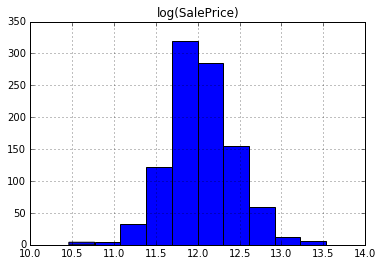

In [21]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [22]:
base_train, stack_train = train.split_frame([0.5], seed=12345)
base_valid, stack_valid = valid.split_frame([0.5], seed=12345)
print(base_train.shape)
print(base_valid.shape)
print(stack_train.shape)
print(stack_valid.shape)

(504, 3205)
(230, 3205)
(497, 3205)
(229, 3205)


#### Define model with grid search function

In [23]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


## Train base level models

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_1_model_3   
1     [0.5]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_1_model_2   
2    [0.25]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_1_model_1   
3    [0.01]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_1_model_0   

   residual_deviance  
0  4.025940991543426  
1  4.037235202840883  
2  4.058507339499796  
3  4.491994155264081  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_1_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.0215644048394
RMSE: 0.146848237441
MAE: 0.0968636763708
RMSLE: 0.0113642283417
R^2: 0.862319569887
Mean Residual Deviance: 0.0215644048394
Null degrees of freedom: 503
Residual degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-11 11:44:31,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-11 11:44:31,0.001 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-11 11:44:31,0.003 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-11 11:44:31,0.004 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-11 11:44:31,0.006 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-11 11:44:32,1.385 sec,0,.39E-2,28,0.0211140,0.0177064
,2017-06-11 11:44:32,1.409 sec,0,.38E-2,29,0.0210799,0.0177301
,2017-06-11 11:44:32,1.441 sec,0,.36E-2,30,0.0210495,0.0177502
,2017-06-11 11:44:32,1.482 sec,0,.34E-2,30,0.0210200,0.0177665



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9833
12.2061,12.3454
11.6784,11.6651
11.914,11.8164
12.6758,12.4798
12.861,12.7562
12.1035,12.0074
11.2898,11.3823
11.7714,11.7068
11.5843,11.4633


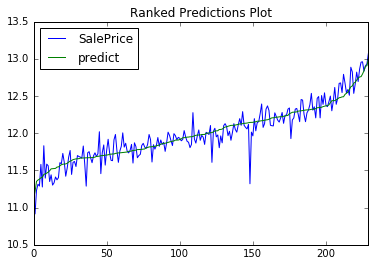

In [24]:
glm0 = glm_grid(original_nums, 'SalePrice', base_train, base_valid)

#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_2_model_3   
1     [0.5]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_2_model_2   
2    [0.25]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_2_model_1   
3    [0.01]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_2_model_0   

    residual_deviance  
0  3.4885728891445145  
1  3.4904363096331164  
2  3.4980313337552422  
3   3.996223581261385  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_2_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.0150939049598
RMSE: 0.122857254404
MAE: 0.0853796062523
RMSLE: 0.00954875481955
R^2: 0.903631222729
Mean Residual Deviance: 0.0150939049598
Null degrees of freedom: 503
Residual degre

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-11 11:45:13,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-11 11:45:13,0.004 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-11 11:45:13,0.024 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-11 11:45:13,0.033 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-11 11:45:13,0.042 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-11 11:45:13,0.638 sec,0,.39E-2,53,0.0144188,0.0155839
,2017-06-11 11:45:13,0.648 sec,0,.38E-2,53,0.0143700,0.0156259
,2017-06-11 11:45:13,0.653 sec,0,.36E-2,54,0.0143236,0.0156811
,2017-06-11 11:45:13,0.658 sec,0,.34E-2,54,0.0142813,0.0157517



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.1128
12.2061,12.273
11.6784,11.8203
11.914,11.7812
12.6758,12.4859
12.861,12.6813
12.1035,11.93
11.2898,11.3451
11.7714,11.6452
11.5843,11.485


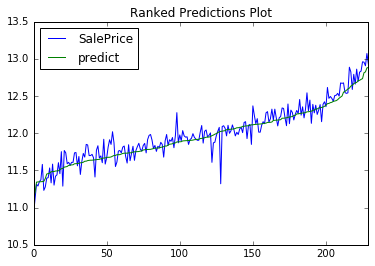

In [25]:
glm1 = glm_grid(encoded_nums, 'SalePrice', base_train, base_valid)

#### Third model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_3_model_0   
1    [0.25]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_3_model_1   
2     [0.5]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_3_model_2   
3    [0.99]  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_3_model_3   

    residual_deviance  
0   3.374448857815197  
1  3.6401646053047854  
2   3.654940127494247  
3   3.693251907061741  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_b21f_model_python_1497195175535_3_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.0132006502449
RMSE: 0.114894082724
MAE: 0.081992486008
RMSLE: 0.00896216167634
R^2: 0.91571892584
Mean Residual Deviance: 0.0132006502449
Null degrees of freedom: 503
Residual degrees

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-11 11:45:31,0.000 sec,0,.32E2,29,0.1539901,0.1482904
,2017-06-11 11:45:31,0.208 sec,0,.3E2,37,0.1490560,0.1437262
,2017-06-11 11:45:32,0.401 sec,0,.29E2,61,0.1432802,0.1384600
,2017-06-11 11:45:32,0.478 sec,0,.27E2,96,0.1364254,0.1323264
,2017-06-11 11:45:32,0.588 sec,0,.26E2,114,0.1292828,0.1259531
---,---,---,---,---,---,---,---
,2017-06-11 11:46:40,1 min 8.847 sec,0,.4E0,684,0.0123063,0.0157754
,2017-06-11 11:46:41,1 min 10.035 sec,0,.38E0,680,0.0121825,0.0160873
,2017-06-11 11:46:43,1 min 11.269 sec,0,.36E0,677,0.0120618,0.0164256
,2017-06-11 11:46:44,1 min 12.843 sec,0,.35E0,672,0.0119438,0.0167876



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0929
12.2061,12.1957
11.6784,11.8061
11.914,11.7908
12.6758,12.4602
12.861,12.664
12.1035,11.9507
11.2898,11.3781
11.7714,11.6666
11.5843,11.5337


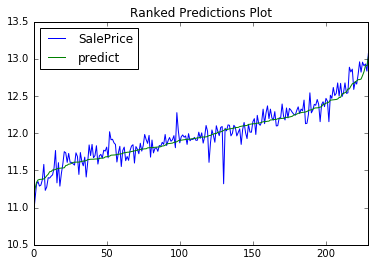

In [26]:
glm2 = glm_grid(encoded_combined_nums, 'SalePrice', base_train, base_valid)

## Train combiner model on second level data

#### Add prediction features to second level data and test data

In [27]:
stack_train = stack_train.cbind(glm0.predict(stack_train))
stack_valid = stack_valid.cbind(glm0.predict(stack_valid))
stack_train = stack_train.cbind(glm1.predict(stack_train))
stack_valid = stack_valid.cbind(glm1.predict(stack_valid))
stack_train = stack_train.cbind(glm2.predict(stack_train))
stack_valid = stack_valid.cbind(glm2.predict(stack_valid))

test = test.cbind(glm0.predict(test))
test = test.cbind(glm1.predict(test))
test = test.cbind(glm2.predict(test))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


#### Train stack model

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0     [0.5]  Grid_GLM_py_310_sid_b21f_model_python_1497195175535_4_model_2   
1    [0.25]  Grid_GLM_py_310_sid_b21f_model_python_1497195175535_4_model_1   
2    [0.99]  Grid_GLM_py_310_sid_b21f_model_python_1497195175535_4_model_3   
3    [0.01]  Grid_GLM_py_310_sid_b21f_model_python_1497195175535_4_model_0   

    residual_deviance  
0   3.157344480313511  
1   3.168314646248289  
2   3.252692874443157  
3  3.7511538959367354  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_310_sid_b21f_model_python_1497195175535_4_model_2


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.0131861209491
RMSE: 0.114830836229
MAE: 0.0816339712335
RMSLE: 0.00893662542487
R^2: 0.913682334465
Mean Residual Deviance: 0.0131861209491
Null degrees of freedom: 496
Residual degre

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-11 11:51:01,0.000 sec,0,.7E0,3,0.1436399,0.1773126
,2017-06-11 11:51:01,0.084 sec,0,.66E0,3,0.1342415,0.1654547
,2017-06-11 11:51:01,0.145 sec,0,.63E0,3,0.1255174,0.1544250
,2017-06-11 11:51:01,0.208 sec,0,.6E0,3,0.1174053,0.1441455
,2017-06-11 11:51:01,0.313 sec,0,.58E0,3,0.1098809,0.1345888
---,---,---,---,---,---,---,---
,2017-06-11 11:51:08,7.792 sec,0,.88E-2,80,0.0099657,0.0150471
,2017-06-11 11:51:09,7.943 sec,0,.84E-2,85,0.0098684,0.0151770
,2017-06-11 11:51:09,8.073 sec,0,.8E-2,84,0.0097672,0.0153099
,2017-06-11 11:51:09,8.284 sec,0,.76E-2,86,0.0096673,0.0154216



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.8964
11.9117,11.9742
11.9767,11.9817
11.8451,11.7998
11.1346,11.3061
11.8845,11.9415
11.9382,11.8829
11.8565,11.7301
11.9704,12.0702
12.6667,12.5792


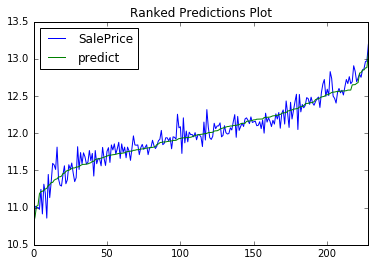

In [28]:
glm3 = glm_grid(encoded_combined_nums + ['predict', 'predict0', 'predict1'], 'SalePrice', stack_train, stack_valid)

#### Score test data

In [29]:
sub = test['Id'].cbind(glm3.predict(test))
sub['predict'] = sub['predict'].exp()
print(sub.head())

glm prediction progress: |████████████████████████████████████████████████| 100%


Id,predict
1461,110110
1462,146265
1463,164337
1464,184702
1465,202877
1466,162703
1467,176488
1468,160274
1469,181217
1470,113874


#### Create submission

In [31]:
# create time stamp
import re
import time
time_stamp = re.sub('[: ]', '_', time.asctime())

# save file for submission
sub.columns = ['Id', 'SalePrice']
sub_fname = '../Desktop/submission_' + str(time_stamp) + '.csv'
h2o.download_csv(sub, sub_fname)

In [28]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_9c9b closed.
